In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/crop-yield-prediction-dataset/yield.csv
/kaggle/input/crop-yield-prediction-dataset/temp.csv
/kaggle/input/crop-yield-prediction-dataset/rainfall.csv
/kaggle/input/crop-yield-prediction-dataset/pesticides.csv
/kaggle/input/crop-yield-prediction-dataset/yield_df.csv


In [2]:
import numpy as np 
import math
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder

from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.model_selection import TimeSeriesSplit

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, Input
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, make_scorer

In [3]:
cropData = pd.read_csv('/kaggle/input/crop-yield-prediction-dataset/yield_df.csv')
print(cropData.head())

   Unnamed: 0     Area         Item  Year  hg/ha_yield  \
0           0  Albania        Maize  1990        36613   
1           1  Albania     Potatoes  1990        66667   
2           2  Albania  Rice, paddy  1990        23333   
3           3  Albania      Sorghum  1990        12500   
4           4  Albania     Soybeans  1990         7000   

   average_rain_fall_mm_per_year  pesticides_tonnes  avg_temp  
0                         1485.0              121.0     16.37  
1                         1485.0              121.0     16.37  
2                         1485.0              121.0     16.37  
3                         1485.0              121.0     16.37  
4                         1485.0              121.0     16.37  


In [4]:
cropData.dropna(axis=0)
cropData = cropData.drop(['Unnamed: 0'], axis=1) # Dropping Unnamed column to not create bias.
cropData.head()

,Area,Item,Year,hg/ha_yield,average_rain_fall_mm_per_year,pesticides_tonnes,avg_temp
0,Albania,Maize,1990,36613,1485.0,121.0,16.37
1,Albania,Potatoes,1990,66667,1485.0,121.0,16.37
2,Albania,"Rice, paddy",1990,23333,1485.0,121.0,16.37
3,Albania,Sorghum,1990,12500,1485.0,121.0,16.37
4,Albania,Soybeans,1990,7000,1485.0,121.0,16.37


>Label Encode catagorical data to numerical data

In [5]:
le = LabelEncoder()
for col in ['Area', 'Item']:
    cropData.loc[:, col] = le.fit_transform(cropData[col])

cropData.head()

,Area,Item,Year,hg/ha_yield,average_rain_fall_mm_per_year,pesticides_tonnes,avg_temp
0,0,1,1990,36613,1485.0,121.0,16.37
1,0,3,1990,66667,1485.0,121.0,16.37
2,0,4,1990,23333,1485.0,121.0,16.37
3,0,5,1990,12500,1485.0,121.0,16.37
4,0,6,1990,7000,1485.0,121.0,16.37


**TEMPORAL SPLITING**
>split the data to training_validation and testing data
>>data upto 2011 will be training data where as data from 2012 onwards will be testing data

In [6]:
# A. Temporal Splitting (Year-Based)
data_sorted = cropData.sort_values(by='Year')

# Combine train and validation years
train_val_temp = data_sorted[data_sorted['Year'] <= 2011]  # Up to 2011 inclusive
test_temp = data_sorted[data_sorted['Year'] > 2011]
print(train_val_temp.head())
print("\n\n")
print(test_temp.head())

      Area Item  Year  hg/ha_yield  average_rain_fall_mm_per_year  \
0        0    1  1990        36613                         1485.0   
14575   43    6  1990        11149                         2702.0   
14576   43    6  1990        11149                         2702.0   
14577   43    6  1990        11149                         2702.0   
14578   43    6  1990        11149                         2702.0   

       pesticides_tonnes  avg_temp  
0                  121.0     16.37  
14575             2432.0     27.05  
14576             2432.0     27.11  
14577             2432.0     27.18  
14578             2432.0     26.79  



      Area Item  Year  hg/ha_yield  average_rain_fall_mm_per_year  \
14218   42    0  2012       385818                         1083.0   
6900    22    0  2012        96365                         3240.0   
6904    22    2  2012        80883                         3240.0   
6905    22    3  2012       181661                         3240.0   
6906    22    3

>prepare the datas by catagorizing with features and label

In [7]:
# Split train_val into train and validation
# data before 2012
train_temp_X = train_val_temp.drop(['hg/ha_yield'], axis=1)
train_temp_y = train_val_temp['hg/ha_yield']

# datas after 2011
test_temp_X = test_temp.drop(['hg/ha_yield'], axis=1)
test_temp_y = test_temp['hg/ha_yield']

>scale the temporal data

In [8]:
scaler_temp_X = StandardScaler()

scaler_temp_X.fit(train_temp_X)

train_temp_X_scaled = scaler_temp_X.transform(train_temp_X)
test_temp_X_scaled = scaler_temp_X.transform(test_temp_X)

train_temp_X_scaled = pd.DataFrame(train_temp_X_scaled, columns=train_temp_X.columns, index=train_temp_X.index)
test_temp_X_scaled = pd.DataFrame(test_temp_X_scaled, columns=test_temp_X.columns, index=test_temp_X.index)


**SPATIAL SPLITING**
>split the data to training_validation and testing data
>>Sorting the data with area and separating it with area

In [9]:
unique_areas = cropData['Area'].unique()

# Calculate number of areas for train/val split (75%)
num_train_val_areas = int(0.75 * len(unique_areas))

# Randomly select areas for train/val
np.random.seed(42)  # For reproducibility
train_val_areas = np.random.choice(unique_areas, size=num_train_val_areas, replace=False)
test_areas = np.setdiff1d(unique_areas, train_val_areas)

# Filter data based on chosen areas
train_val_spatial = cropData[cropData['Area'].isin(train_val_areas)]
test_spatial = cropData[cropData['Area'].isin(test_areas)]

# Split train_val into train and validation (optional)
train_spatial_X = train_val_spatial.drop(['hg/ha_yield'], axis=1)
train_spatial_y = train_val_spatial['hg/ha_yield']

test_spatial_X = test_spatial.drop(['hg/ha_yield'], axis=1)
test_spatial_y = test_spatial['hg/ha_yield']


> Scale the spatial data

In [10]:
scaler_spatial_X = StandardScaler()
scaler_spatial_X.fit(train_spatial_X)

train_spatial_X_scaled = scaler_spatial_X.transform(train_spatial_X)
test_spatial_X_scaled = scaler_spatial_X.transform(test_spatial_X)

train_spatial_X_scaled = pd.DataFrame(train_spatial_X_scaled, columns=train_spatial_X.columns, index=train_spatial_X.index)
test_spatial_X_scaled = pd.DataFrame(test_spatial_X_scaled, columns=test_spatial_X.columns, index=test_spatial_X.index)


**Working with RANDOM FOREST REGRESSOR**
>Tune the Random model by chaging the parameters inorder to find the best model for **Temporal Data**

In [11]:
randomModel = RandomForestRegressor()
randomModel.fit(train_temp_X_scaled, train_temp_y)

predictions_temp = randomModel.predict(test_temp_X_scaled)
mse_temp = mean_squared_error(test_temp_y, predictions_temp)
rmse_temp = np.sqrt(mse_temp)
mae_temp = mean_absolute_error(test_temp_y, predictions_temp)
r2_temp = r2_score(test_temp_y, predictions_temp)
print("\nTemporal Model Evaluation (Test Set):")
print(f"MSE: {mse_temp}, RMSE: {rmse_temp}, MAE: {mae_temp}, R-squared: {r2_temp}")


Temporal Model Evaluation (Test Set):
MSE: 379649147.41866493, RMSE: 19484.587432600798, MAE: 9464.18515283843, R-squared: 0.9589176466154075


In [12]:
# Hyperparameter Tuning and Model Selection (Temporal Only)
param_grid = {'n_estimators': [20, 30, 50, 75, 100], 'max_depth': [10, 20, 30]}
grid_search_temp = GridSearchCV(RandomForestRegressor(random_state=42), param_grid, 
                                cv=5, scoring='neg_root_mean_squared_error', return_train_score=True, n_jobs=1)
grid_search_temp.fit(train_temp_X_scaled, train_temp_y)
best_rf_temp = grid_search_temp.best_estimator_
best_rf_score = grid_search_temp.best_score_
print(best_rf_score)

-17826.96013919159


>displaying the best parameters

In [13]:
print(grid_search_temp.best_params_)

{'max_depth': 20, 'n_estimators': 30}


>testing the best model that we got using the test data of **Temporal Data**

In [14]:
predictions_temp = best_rf_temp.predict(test_temp_X_scaled)
mse_temp = mean_squared_error(test_temp_y, predictions_temp)
rmse_temp = np.sqrt(mse_temp)
mae_temp = mean_absolute_error(test_temp_y, predictions_temp)
r2_temp = r2_score(test_temp_y, predictions_temp)
residuals_temp = test_temp_y - predictions_temp #Calculate residuals for temporal data
print("\nTemporal Model Evaluation (Test Set):")
print(f"MSE: {mse_temp}, RMSE: {rmse_temp}, MAE: {mae_temp}, R-squared: {r2_temp}")


Temporal Model Evaluation (Test Set):
MSE: 403903547.42389625, RMSE: 20097.35175150936, MAE: 9785.688215488632, R-squared: 0.9562930448247248


>another hyper parameter tuning to see if we can get a much better model for the **Temporal Data** 

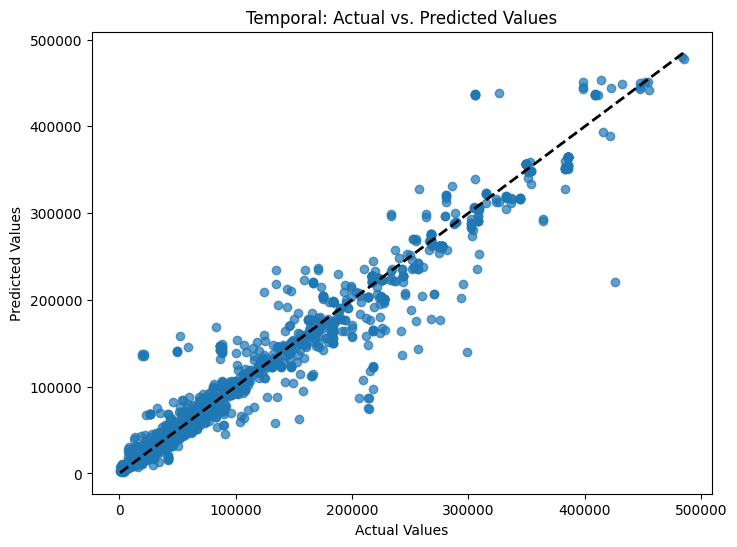

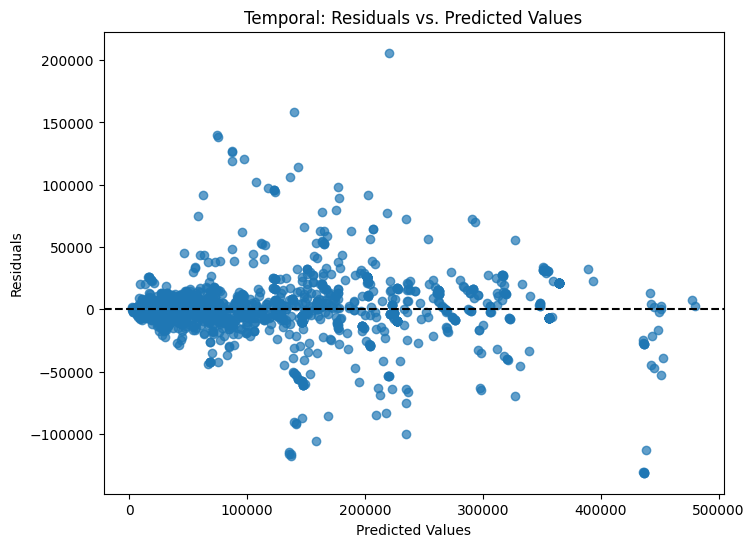

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


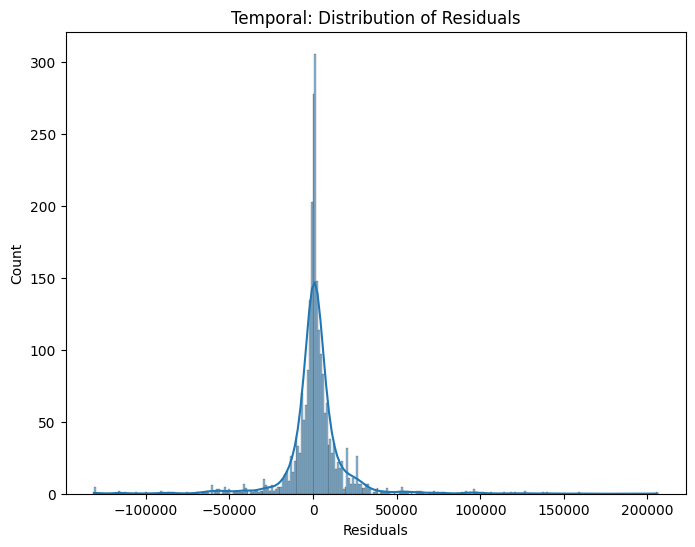

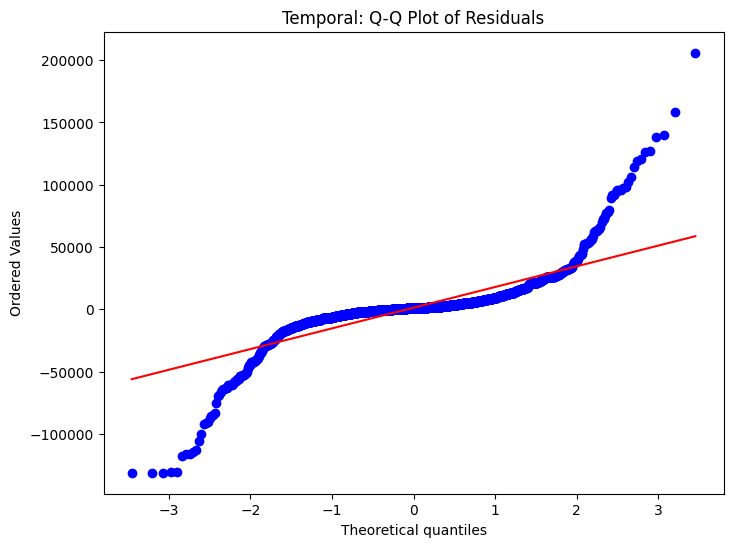

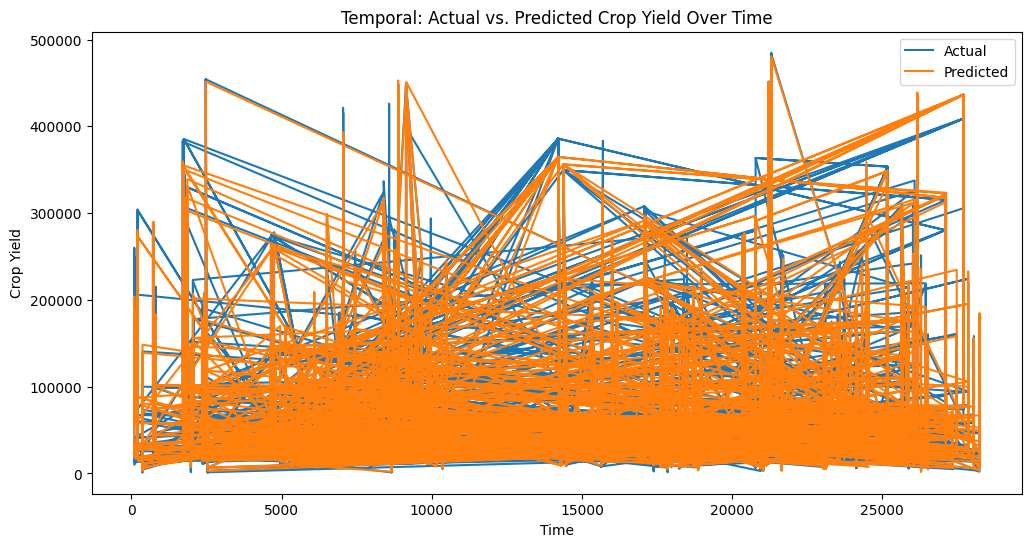

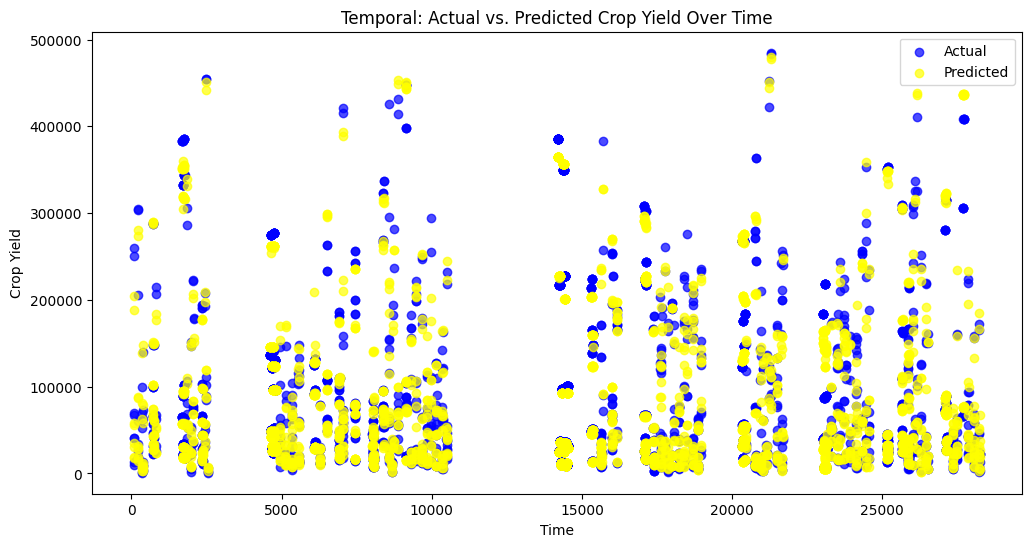

In [15]:
# Plots for TEMPORAL model
# Actual vs. Predicted Values (Scatter Plot)
plt.figure(figsize=(8, 6))
plt.scatter(test_temp_y, predictions_temp, alpha=0.7)
plt.plot([test_temp_y.min(), test_temp_y.max()], [test_temp_y.min(), test_temp_y.max()], 'k--', lw=2)
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Temporal: Actual vs. Predicted Values") #Added Temporal to the title
plt.show()

# Residuals vs. Predicted Values (Residual Plot)
plt.figure(figsize=(8, 6))
plt.scatter(predictions_temp, residuals_temp, alpha=0.7)
plt.axhline(y=0, color='k', linestyle='--')
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.title("Temporal: Residuals vs. Predicted Values")#Added Temporal to the title
plt.show()

# Distribution of Residuals (Histogram or KDE)
plt.figure(figsize=(8, 6))
sns.histplot(residuals_temp, kde=True)
plt.xlabel("Residuals")
plt.title("Temporal: Distribution of Residuals")#Added Temporal to the title
plt.show()

# Q-Q Plot (Quantile-Quantile Plot)
plt.figure(figsize=(8, 6))
stats.probplot(residuals_temp, dist="norm", plot=plt)
plt.title("Temporal: Q-Q Plot of Residuals")#Added Temporal to the title
plt.show()

# Prediction Error Plot 
predictions_df_temp = pd.DataFrame({'Actual': test_temp_y, 'Predicted': predictions_temp}, index = test_temp_y.index)
plt.figure(figsize=(12, 6))
plt.plot(predictions_df_temp['Actual'], label='Actual')
plt.plot(predictions_df_temp['Predicted'], label='Predicted')
plt.xlabel("Time")
plt.ylabel("Crop Yield")
plt.title("Temporal: Actual vs. Predicted Crop Yield Over Time")#Added Temporal to the title
plt.legend()
plt.show()

predictions_df_temp = pd.DataFrame({'Actual': test_temp_y, 'Predicted': predictions_temp}, index = test_temp_y.index)

plt.figure(figsize=(12, 6))

# Scatter plot for actual values
plt.scatter(predictions_df_temp.index, predictions_df_temp['Actual'], label='Actual', color='blue', alpha=0.7)

# Scatter plot for predicted values
plt.scatter(predictions_df_temp.index, predictions_df_temp['Predicted'], label='Predicted', color='yellow', alpha=0.7)

plt.xlabel("Time")
plt.ylabel("Crop Yield")
plt.title("Temporal: Actual vs. Predicted Crop Yield Over Time")  # Added Temporal to the title
plt.legend()
plt.show()


In [16]:
# Hyperparameter Tuning and Model Selection (Temporal Only)
param_grid = {'n_estimators': [50, 100, 200, 250, 300], 'max_depth': [30, 50, 100, 200]}
grid_search_temp = GridSearchCV(RandomForestRegressor(random_state=42), param_grid, cv=5, scoring='neg_root_mean_squared_error', return_train_score=True, n_jobs=1)
grid_search_temp.fit(train_temp_X_scaled, train_temp_y)
best_rf_temp = grid_search_temp.best_estimator_
best_rf_score = grid_search_temp.best_score_
print(best_rf_score)

-17875.94649466963


>displaying the best parameters

In [17]:
print(grid_search_temp.best_params_)

{'max_depth': 30, 'n_estimators': 250}


>Testing the model on **Temporal Data** using the test data on the best model we have got after tuning it for the second time

In [18]:
predictions_temp = best_rf_temp.predict(test_temp_X_scaled)
mse_temp = mean_squared_error(test_temp_y, predictions_temp)
rmse_temp = np.sqrt(mse_temp)
mae_temp = mean_absolute_error(test_temp_y, predictions_temp)
r2_temp = r2_score(test_temp_y, predictions_temp)
print("\nTemporal Model Evaluation (Test Set):")
print(f"MSE: {mse_temp}, RMSE: {rmse_temp}, MAE: {mae_temp}, R-squared: {r2_temp}")


Temporal Model Evaluation (Test Set):
MSE: 377242376.35386616, RMSE: 19422.72834474771, MAE: 9428.372303310081, R-squared: 0.9591780866034125


In [19]:
param_grid_temp = {
    'n_estimators': [250, 300],
    'max_depth': [20, 30, 50],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'max_features': ["sqrt", "log2"]
}

rmse_scorer_temp = make_scorer(lambda y_true, y_pred: math.sqrt(mean_squared_error(y_true, y_pred)), greater_is_better=False)

grid_search_temp = GridSearchCV(
    RandomForestRegressor(random_state=42, oob_score=True),
    param_grid_temp,
    cv=5,
    scoring=rmse_scorer_temp,
    return_train_score=True,
    n_jobs=1
)

grid_search_temp.fit(train_temp_X_scaled, train_temp_y)
best_rf_temp = grid_search_temp.best_estimator_
best_rmse_temp = grid_search_temp.best_score_
cv_results_temp = grid_search_temp.cv_results_
print("Temporal Best RMSE:", best_rmse_temp)
print("Temporal Best Estimator:", best_rf_temp)
results_df_temp = pd.DataFrame(cv_results_temp)
print(results_df_temp.head())

Temporal Best RMSE: -16676.988953256845
Temporal Best Estimator: RandomForestRegressor(max_depth=30, max_features='sqrt', n_estimators=250,
                      oob_score=True, random_state=42)
   mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0       6.809935      0.129667         0.243281        0.012607   
1       8.071648      0.061962         0.291595        0.010136   
2       5.938585      0.042606         0.207836        0.007116   
3       7.124482      0.066320         0.247755        0.010632   
4       5.899112      0.035468         0.210031        0.009219   

  param_max_depth param_max_features param_min_samples_leaf  \
0              20               sqrt                      1   
1              20               sqrt                      1   
2              20               sqrt                      1   
3              20               sqrt                      1   
4              20               sqrt                      2   

  param_min_samples_spl

In [20]:
predictions_temp = best_rf_temp.predict(test_temp_X_scaled)
mse_temp = mean_squared_error(test_temp_y, predictions_temp)
rmse_temp = np.sqrt(mse_temp)
mae_temp = mean_absolute_error(test_temp_y, predictions_temp)
r2_temp = r2_score(test_temp_y, predictions_temp)
print("\nTemporal Model Evaluation (Test Set):")
print(f"MSE: {mse_temp}, RMSE: {rmse_temp}, MAE: {mae_temp}, R-squared: {r2_temp}")


Temporal Model Evaluation (Test Set):
MSE: 361397821.73568195, RMSE: 19010.466110426696, MAE: 9847.768336641524, R-squared: 0.9608926475249149


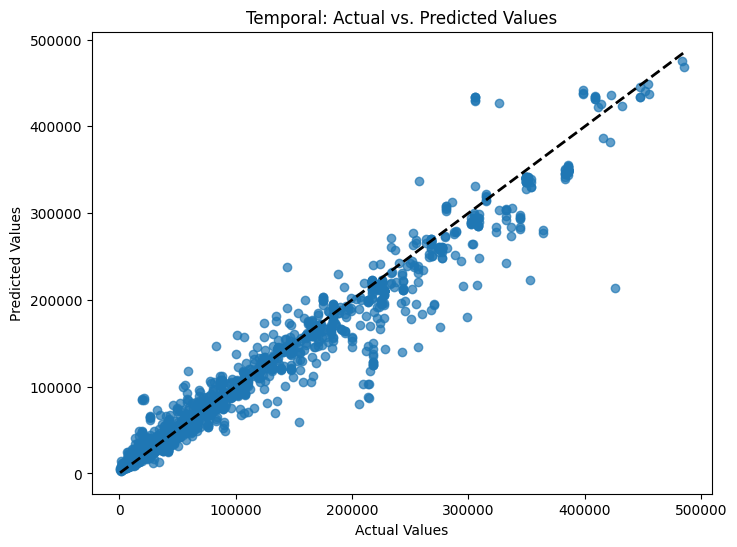

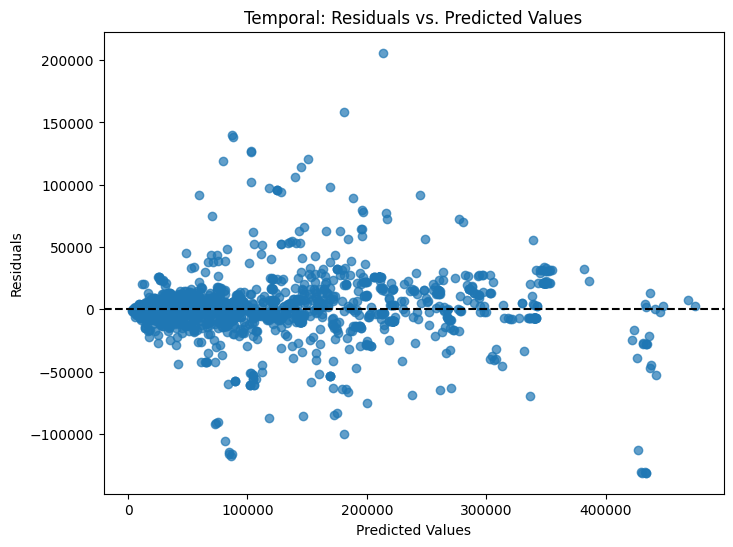

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


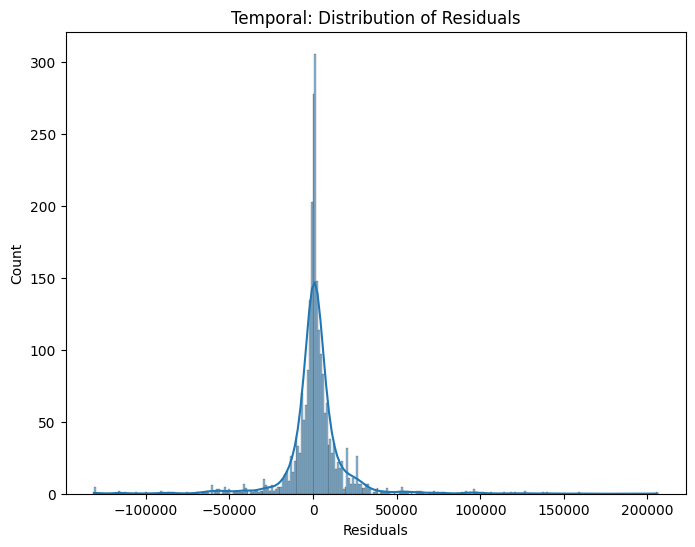

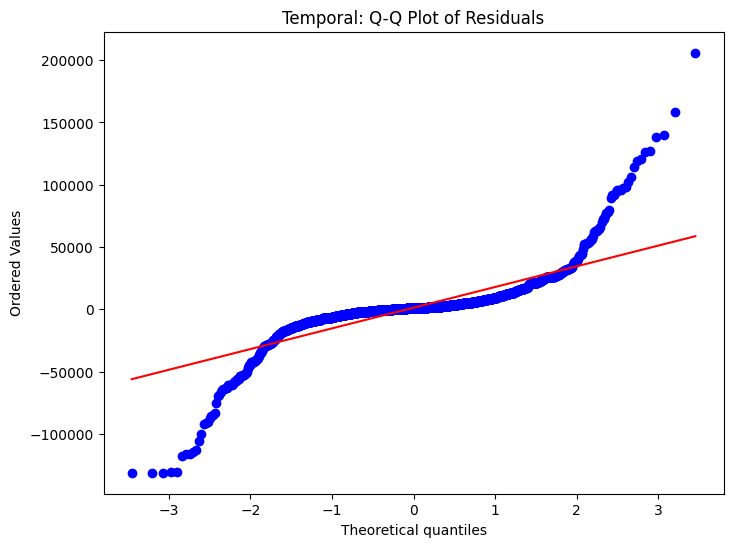

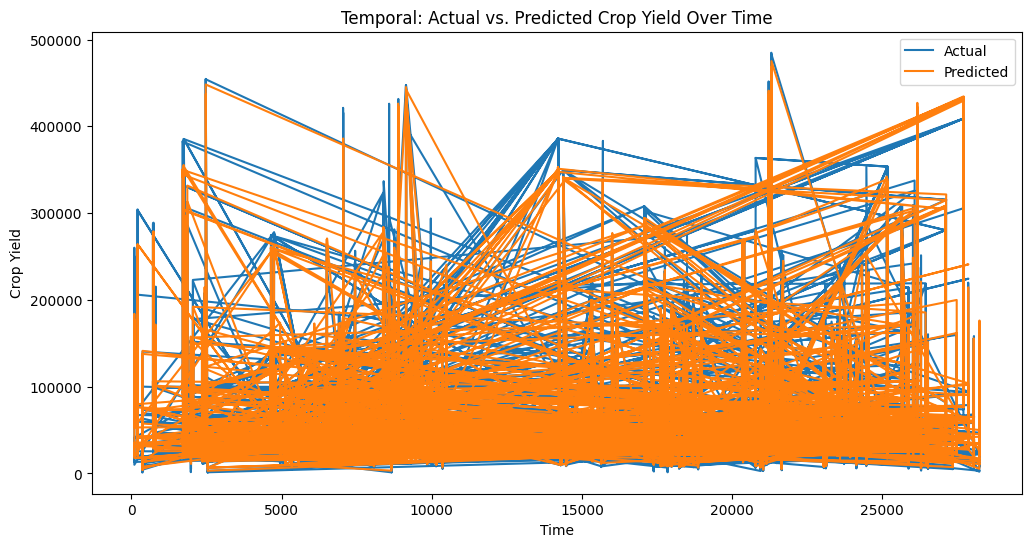

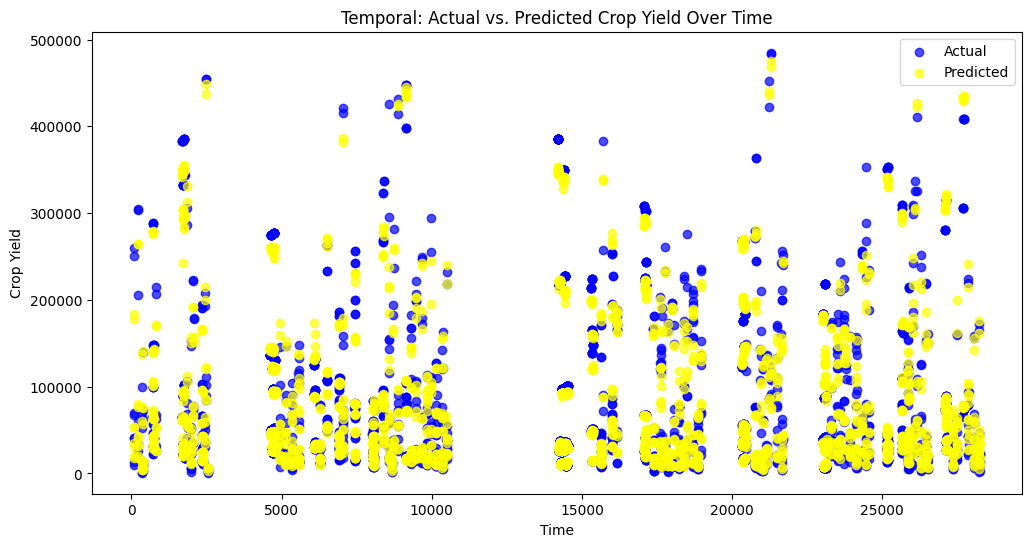

In [21]:
# Plots for TEMPORAL model
# Actual vs. Predicted Values (Scatter Plot)
plt.figure(figsize=(8, 6))
plt.scatter(test_temp_y, predictions_temp, alpha=0.7)
plt.plot([test_temp_y.min(), test_temp_y.max()], [test_temp_y.min(), test_temp_y.max()], 'k--', lw=2)
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Temporal: Actual vs. Predicted Values") #Added Temporal to the title
plt.show()

# Residuals vs. Predicted Values (Residual Plot)
plt.figure(figsize=(8, 6))
plt.scatter(predictions_temp, residuals_temp, alpha=0.7)
plt.axhline(y=0, color='k', linestyle='--')
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.title("Temporal: Residuals vs. Predicted Values")#Added Temporal to the title
plt.show()

# Distribution of Residuals (Histogram or KDE)
plt.figure(figsize=(8, 6))
sns.histplot(residuals_temp, kde=True)
plt.xlabel("Residuals")
plt.title("Temporal: Distribution of Residuals")#Added Temporal to the title
plt.show()

# Q-Q Plot (Quantile-Quantile Plot)
plt.figure(figsize=(8, 6))
stats.probplot(residuals_temp, dist="norm", plot=plt)
plt.title("Temporal: Q-Q Plot of Residuals")#Added Temporal to the title
plt.show()

# Prediction Error Plot 
predictions_df_temp = pd.DataFrame({'Actual': test_temp_y, 'Predicted': predictions_temp}, index = test_temp_y.index)
plt.figure(figsize=(12, 6))
plt.plot(predictions_df_temp['Actual'], label='Actual')
plt.plot(predictions_df_temp['Predicted'], label='Predicted')
plt.xlabel("Time")
plt.ylabel("Crop Yield")
plt.title("Temporal: Actual vs. Predicted Crop Yield Over Time")#Added Temporal to the title
plt.legend()
plt.show()

predictions_df_temp = pd.DataFrame({'Actual': test_temp_y, 'Predicted': predictions_temp}, index = test_temp_y.index)

plt.figure(figsize=(12, 6))

# Scatter plot for actual values
plt.scatter(predictions_df_temp.index, predictions_df_temp['Actual'], label='Actual', color='blue', alpha=0.7)

# Scatter plot for predicted values
plt.scatter(predictions_df_temp.index, predictions_df_temp['Predicted'], label='Predicted', color='yellow', alpha=0.7)

plt.xlabel("Time")
plt.ylabel("Crop Yield")
plt.title("Temporal: Actual vs. Predicted Crop Yield Over Time")  # Added Temporal to the title
plt.legend()
plt.show()


**########**

**SPATIAL DATA**
>Tune the Random model by chaging the parameters inorder to find the best model for **spatial data**

In [22]:
randomModel = RandomForestRegressor()
randomModel.fit(train_spatial_X_scaled, train_spatial_y)

predictions_spatial = randomModel.predict(test_spatial_X_scaled)
mse_spatial = mean_squared_error(test_spatial_y, predictions_spatial)
rmse_spatial = np.sqrt(mse_spatial)
mae_spatial = mean_absolute_error(test_spatial_y, predictions_spatial)
r2_spatial = r2_score(test_spatial_y, predictions_spatial)
print("\nTemporal Model Evaluation (Test Set):")
print(f"MSE: {mse_spatial}, RMSE: {rmse_spatial}, MAE: {mae_spatial}, R-squared: {r2_spatial}")


Temporal Model Evaluation (Test Set):
MSE: 2609142075.0402718, RMSE: 51079.76189294809, MAE: 31503.57006999837, R-squared: 0.44096809592658714


In [23]:
# Hyperparameter Tuning and Model Selection (Spatial Data Only)
param_grid = {'n_estimators': [20, 30, 50, 75, 100], 'max_depth': [10, 20, 30]}
grid_search_spatial = GridSearchCV(RandomForestRegressor(random_state=42), param_grid,
                                   cv=5, scoring='neg_root_mean_squared_error', return_train_score=True, n_jobs=1)
grid_search_spatial.fit(train_spatial_X_scaled, train_spatial_y)
best_rf_spatial = grid_search_spatial.best_estimator_
best_rf_score = grid_search_spatial.best_score_
print(best_rf_score)

-49346.54388581728


>displaying the best parameters

In [24]:
print(grid_search_spatial.best_params_)

{'max_depth': 30, 'n_estimators': 30}


>testing the best model that we got using the test data of **Spatial Data**

In [25]:
predictions_spatial = best_rf_spatial.predict(test_spatial_X_scaled)
mse_spatial = mean_squared_error(test_spatial_y, predictions_spatial)
rmse_spatial = np.sqrt(mse_spatial)
mae_spatial = mean_absolute_error(test_spatial_y, predictions_spatial)
r2_spatial = r2_score(test_spatial_y, predictions_spatial)
print("\nTemporal Model Evaluation (Test Set):")
print(f"MSE: {mse_spatial}, RMSE: {rmse_spatial}, MAE: {mae_spatial}, R-squared: {r2_spatial}")


Temporal Model Evaluation (Test Set):
MSE: 2546644560.396362, RMSE: 50464.28995236495, MAE: 31242.512659395514, R-squared: 0.45435874450240366


In [26]:
param_grid_spatial = {
    'n_estimators': [250, 300],
    'max_depth': [20, 30, 50],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'max_features': ["sqrt", "log2"]
}

rmse_scorer_spatial = make_scorer(lambda y_true, y_pred: math.sqrt(mean_squared_error(y_true, y_pred)), greater_is_better=False)

grid_search_spatial = GridSearchCV(
    RandomForestRegressor(random_state=42, oob_score=True),
    param_grid_spatial,
    cv=5,
    scoring=rmse_scorer_spatial,
    return_train_score=True,
    n_jobs=1
)

grid_search_spatial.fit(train_spatial_X_scaled, train_spatial_y)
best_rf_spatial = grid_search_spatial.best_estimator_
best_rmse_spatial = grid_search_spatial.best_score_
cv_results_spatial = grid_search_spatial.cv_results_
print("Temporal Best RMSE:", best_rmse_spatial)
print("Temporal Best Estimator:", best_rf_spatial)
results_df_spatial = pd.DataFrame(cv_results_spatial)
print(results_df_spatial.head())

Temporal Best RMSE: -45834.28930305716
Temporal Best Estimator: RandomForestRegressor(max_depth=30, max_features='sqrt', min_samples_split=5,
                      n_estimators=250, oob_score=True, random_state=42)
   mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0       5.562475      0.130563         0.104548        0.009193   
1       6.700036      0.147738         0.124957        0.010680   
2       4.911105      0.100635         0.088319        0.008589   
3       5.912819      0.135855         0.107994        0.009879   
4       4.867841      0.098745         0.090278        0.007583   

  param_max_depth param_max_features param_min_samples_leaf  \
0              20               sqrt                      1   
1              20               sqrt                      1   
2              20               sqrt                      1   
3              20               sqrt                      1   
4              20               sqrt                      2   

  p

In [27]:
predictions_spatial = best_rf_spatial.predict(test_spatial_X_scaled)
mse_spatial = mean_squared_error(test_spatial_y, predictions_spatial)
rmse_spatial = np.sqrt(mse_spatial)
mae_spatial = mean_absolute_error(test_spatial_y, predictions_spatial)
r2_spatial = r2_score(test_spatial_y, predictions_spatial)
residuals_spatial = test_spatial_y - predictions_spatial #Calculate residuals for spatialoral data

print("\Spatial Model Evaluation (Test Set):")
print(f"MSE: {mse_spatial}, RMSE: {rmse_spatial}, MAE: {mae_spatial}, R-squared: {r2_spatial}")

\Spatial Model Evaluation (Test Set):
MSE: 1466406907.5389118, RMSE: 38293.692790574685, MAE: 24515.135313901774, R-squared: 0.6858092728985523


**Spatial Graphs**

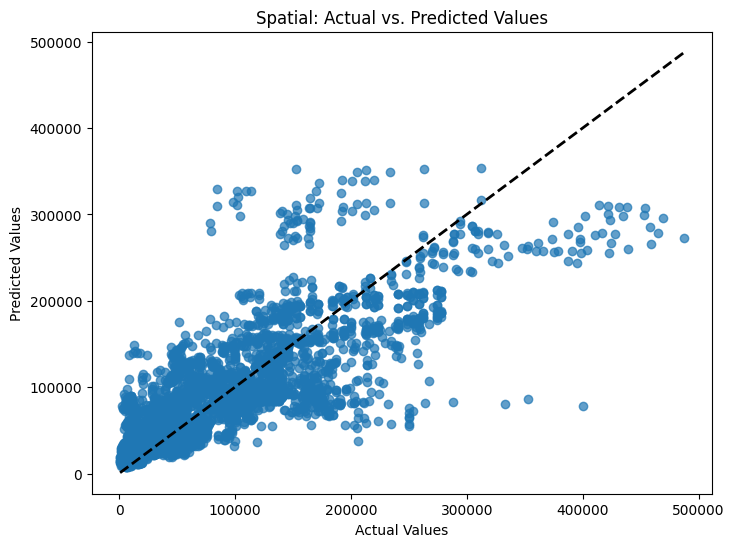

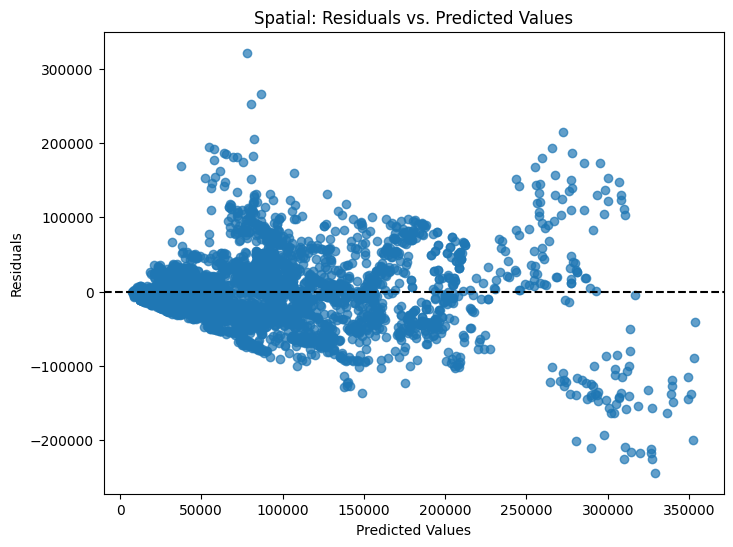

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


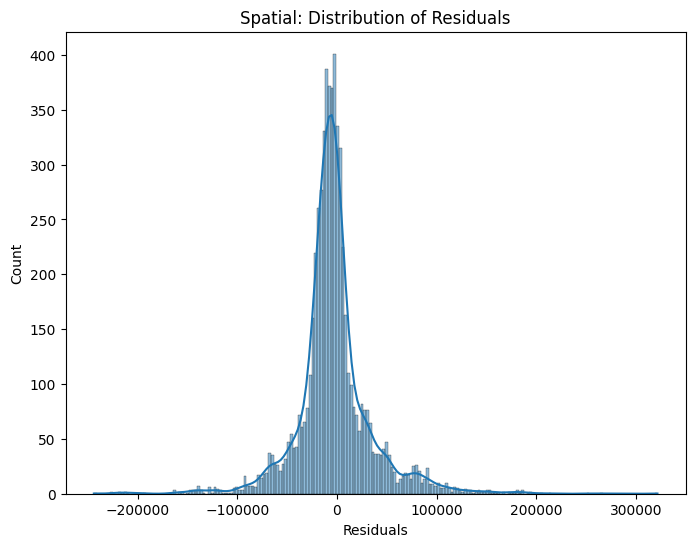

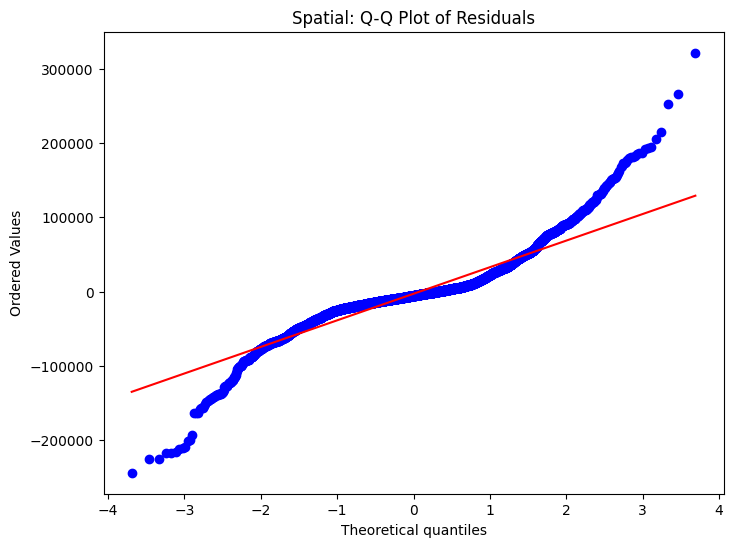

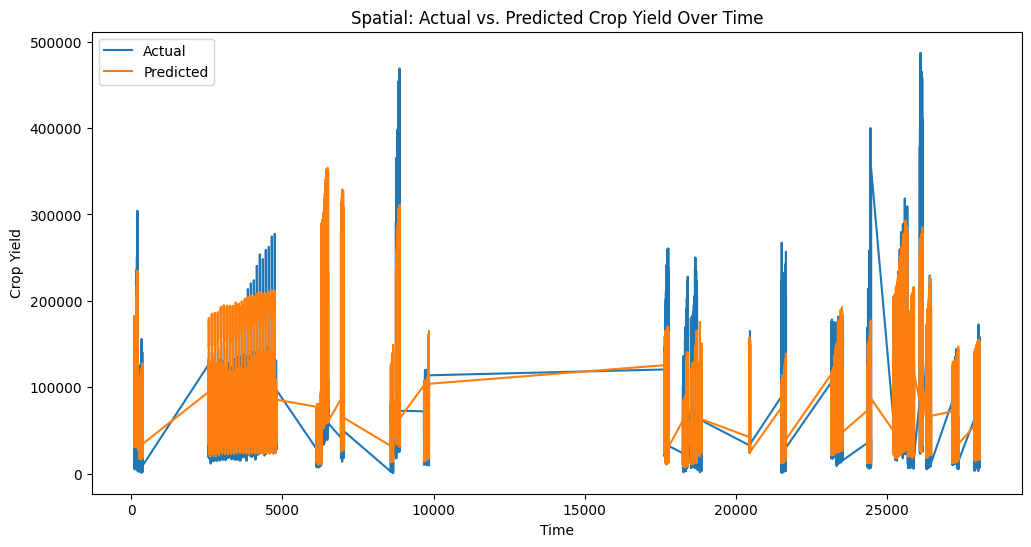

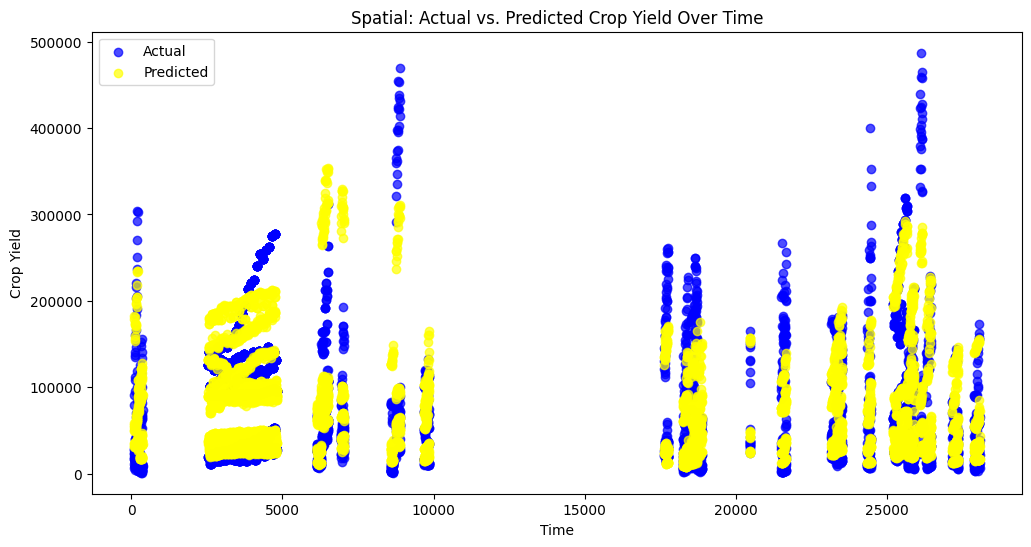

In [28]:
# Plots for Spatial model
# Actual vs. Predicted Values (Scatter Plot)
plt.figure(figsize=(8, 6))
plt.scatter(test_spatial_y, predictions_spatial, alpha=0.7)
plt.plot([test_spatial_y.min(), test_spatial_y.max()], [test_spatial_y.min(), test_spatial_y.max()], 'k--', lw=2)
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Spatial: Actual vs. Predicted Values") #Added Spatial to the title
plt.show()

# Residuals vs. Predicted Values (Residual Plot)
plt.figure(figsize=(8, 6))
plt.scatter(predictions_spatial, residuals_spatial, alpha=0.7)
plt.axhline(y=0, color='k', linestyle='--')
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.title("Spatial: Residuals vs. Predicted Values")#Added Spatial to the title
plt.show()

# Distribution of Residuals (Histogram or KDE)
plt.figure(figsize=(8, 6))
sns.histplot(residuals_spatial, kde=True)
plt.xlabel("Residuals")
plt.title("Spatial: Distribution of Residuals")#Added Spatial to the title
plt.show()

# Q-Q Plot (Quantile-Quantile Plot)
plt.figure(figsize=(8, 6))
stats.probplot(residuals_spatial, dist="norm", plot=plt)
plt.title("Spatial: Q-Q Plot of Residuals")#Added Spatial to the title
plt.show()

# Prediction Error Plot 
predictions_df_spatial = pd.DataFrame({'Actual': test_spatial_y, 'Predicted': predictions_spatial}, index = test_spatial_y.index)
plt.figure(figsize=(12, 6))
plt.plot(predictions_df_spatial['Actual'], label='Actual')
plt.plot(predictions_df_spatial['Predicted'], label='Predicted')
plt.xlabel("Time")
plt.ylabel("Crop Yield")
plt.title("Spatial: Actual vs. Predicted Crop Yield Over Time")#Added Spatial to the title
plt.legend()
plt.show()

predictions_df_spatial = pd.DataFrame({'Actual': test_spatial_y, 'Predicted': predictions_spatial}, index = test_spatial_y.index)

plt.figure(figsize=(12, 6))

# Scatter plot for actual values
plt.scatter(predictions_df_spatial.index, predictions_df_spatial['Actual'], label='Actual', color='blue', alpha=0.7)

# Scatter plot for predicted values
plt.scatter(predictions_df_spatial.index, predictions_df_spatial['Predicted'], label='Predicted', color='yellow', alpha=0.7)

plt.xlabel("Time")
plt.ylabel("Crop Yield")
plt.title("Spatial: Actual vs. Predicted Crop Yield Over Time")  # Added Spatial to the title
plt.legend()
plt.show()


**Working with SUPPORT VECTOR MACHINE**
>Tune the Random model by chaging the parameters inorder to find the best model for **Temporal Data**

In [29]:
randomModel = SVR()
randomModel.fit(train_temp_X_scaled, train_temp_y)

predictions_temp = randomModel.predict(test_temp_X_scaled)
mse_temp = mean_squared_error(test_temp_y, predictions_temp)
rmse_temp = np.sqrt(mse_temp)
mae_temp = mean_absolute_error(test_temp_y, predictions_temp)
r2_temp = r2_score(test_temp_y, predictions_temp)
print("\nTemporal Model Evaluation (Test Set):")
print(f"MSE: {mse_temp}, RMSE: {rmse_temp}, MAE: {mae_temp}, R-squared: {r2_temp}")



Temporal Model Evaluation (Test Set):
MSE: 11914138272.564234, RMSE: 109151.90457598178, MAE: 66097.53612508545, R-squared: -0.28924519418615136


In [30]:
# param_grid_svr = {'C': [0.1, 1, 10, 100], 'gamma': [1, 0.1, 0.01, 0.001], 'kernel': ['rbf', 'linear']} #Example parameter grid

param_grid_svr = {'C': [0.1, 1], 'gamma': [1, 0.1], 'kernel': ['rbf']} #Example parameter grid
grid_search_svr_temp = GridSearchCV(SVR(), param_grid_svr, cv=TimeSeriesSplit(n_splits=5), 
                                    scoring='neg_root_mean_squared_error', return_train_score=True, n_jobs=1) #Use TimeSeriesSplit
grid_search_svr_temp.fit(train_temp_X_scaled, train_temp_y)
best_svr_temp = grid_search_svr_temp.best_estimator_
best_svr_score = grid_search_svr_temp.best_score_
print(best_svr_score)

-95463.6024711183


>Displaying the best parameters of the best model we have got

In [31]:
print(grid_search_svr_temp.best_params_)

{'C': 1, 'gamma': 0.1, 'kernel': 'rbf'}


>testing the best model that we got using the test data of **Temporal Data**

In [32]:
predictions_svr_temp = best_svr_temp.predict(test_temp_X_scaled)
mse_svr_temp = mean_squared_error(test_temp_y, predictions_svr_temp)
rmse_svr_temp = np.sqrt(mse_svr_temp)
mae_svr_temp = mean_absolute_error(test_temp_y, predictions_svr_temp)
r2_svr_temp = r2_score(test_temp_y, predictions_svr_temp)
print("\nTemporal SVR Model Evaluation (Test Set):")
print(f"MSE: {mse_svr_temp}, RMSE: {rmse_svr_temp}, MAE: {mae_svr_temp}, R-squared: {r2_svr_temp}")


Temporal SVR Model Evaluation (Test Set):
MSE: 11914478305.18469, RMSE: 109153.46217681182, MAE: 66095.64636683154, R-squared: -0.2892819895809806


>another hyper parameter tuning to see if we can get a much better model for the **Temporal Data** 

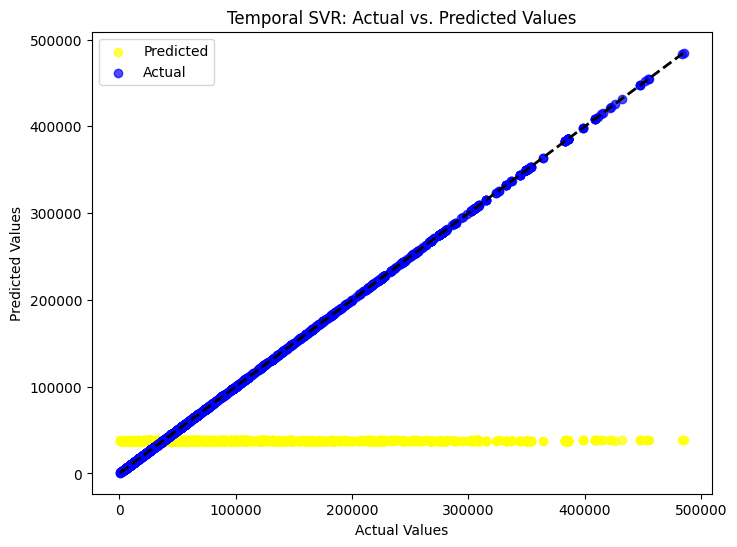

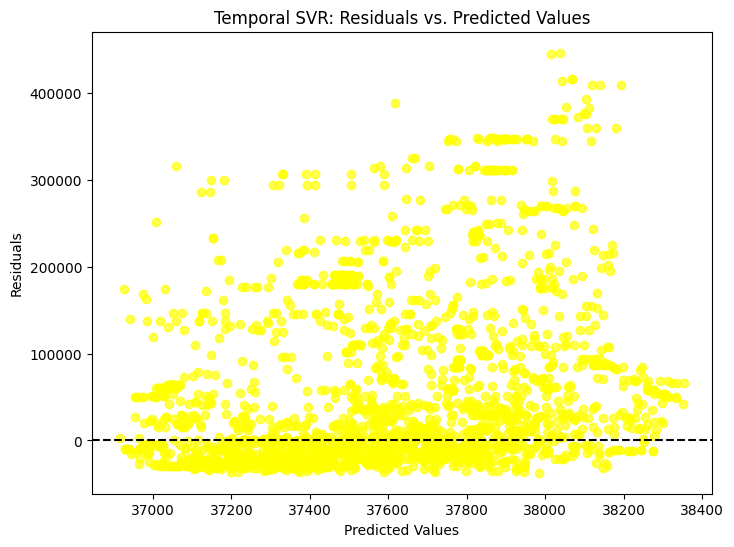

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


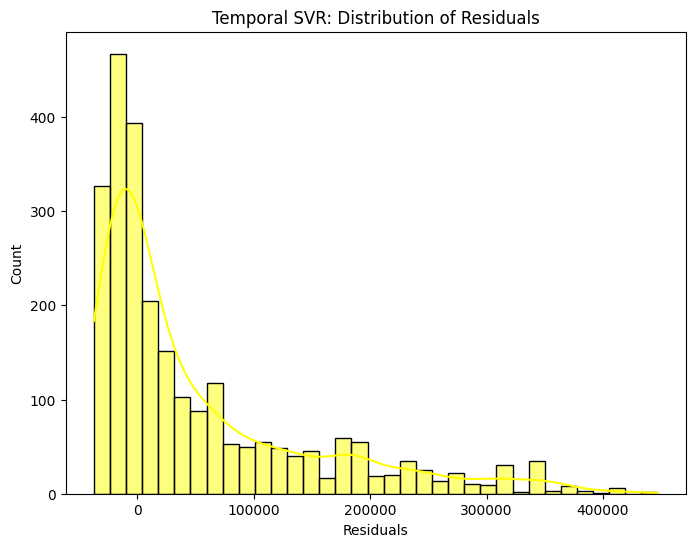

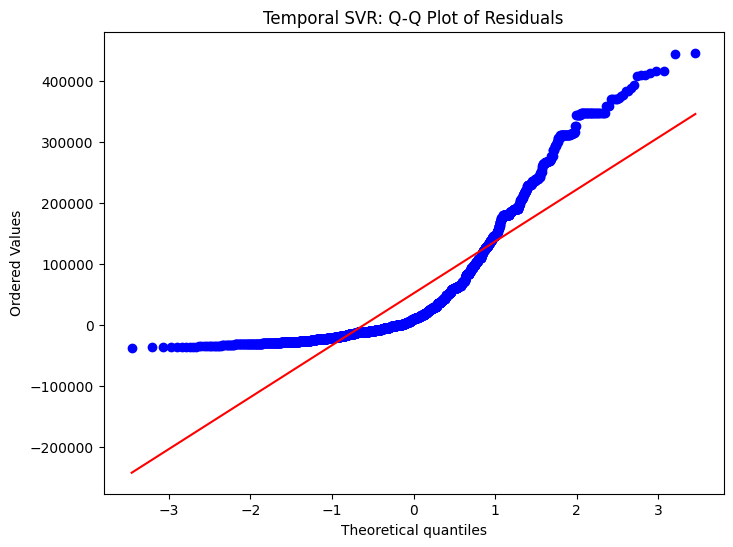

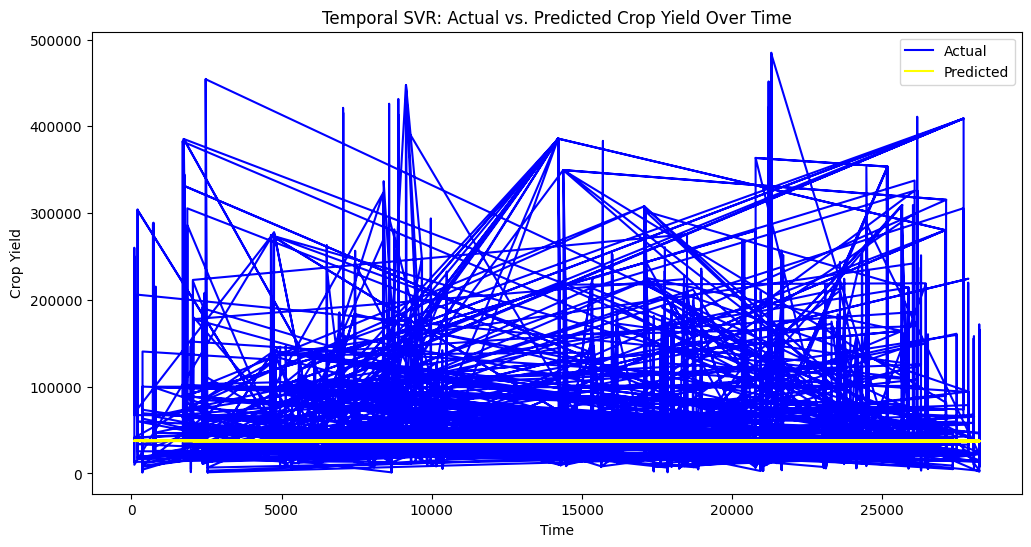

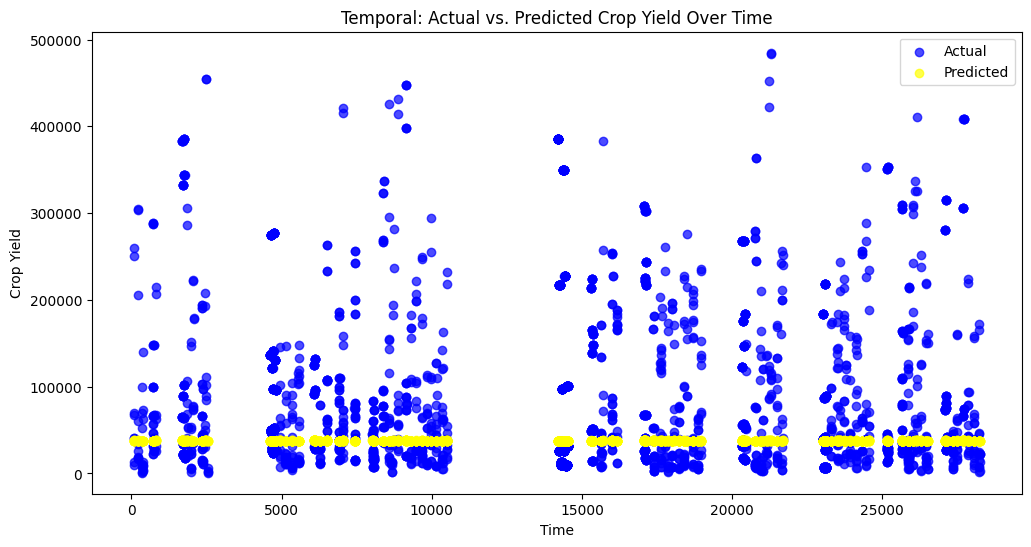

In [33]:
# Scatter Plot: Actual vs. Predicted Values
plt.figure(figsize=(8, 6))
plt.scatter(test_temp_y, predictions_svr_temp, alpha=0.7, color='yellow', label='Predicted')
plt.scatter(test_temp_y, test_temp_y, alpha=0.7, color='blue', label='Actual')  # To distinguish actual vs predicted
plt.plot([test_temp_y.min(), test_temp_y.max()], [test_temp_y.min(), test_temp_y.max()], 'k--', lw=2)
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Temporal SVR: Actual vs. Predicted Values")
plt.legend()
plt.show()

# Residuals vs. Predicted Values (Residual Plot)
residuals_svr_temp = test_temp_y - predictions_svr_temp
plt.figure(figsize=(8, 6))
plt.scatter(predictions_svr_temp, residuals_svr_temp, alpha=0.7, color='yellow')
plt.axhline(y=0, color='k', linestyle='--')
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.title("Temporal SVR: Residuals vs. Predicted Values")
plt.show()

# Distribution of Residuals (Histogram or KDE)
plt.figure(figsize=(8, 6))
sns.histplot(residuals_svr_temp, kde=True, color='yellow')
plt.xlabel("Residuals")
plt.title("Temporal SVR: Distribution of Residuals")
plt.show()

# Q-Q Plot (Quantile-Quantile Plot)
plt.figure(figsize=(8, 6))
stats.probplot(residuals_svr_temp, dist="norm", plot=plt)
plt.title("Temporal SVR: Q-Q Plot of Residuals")
plt.show()

# Prediction Error Plot (Optional, but useful for time series)
predictions_df_svr_temp = pd.DataFrame({'Actual': test_temp_y, 'Predicted': predictions_svr_temp}, index = test_temp_y.index)
plt.figure(figsize=(12, 6))
plt.plot(predictions_df_svr_temp['Actual'], label='Actual', color='blue')
plt.plot(predictions_df_svr_temp['Predicted'], label='Predicted', color='yellow')
plt.xlabel("Time")
plt.ylabel("Crop Yield")
plt.title("Temporal SVR: Actual vs. Predicted Crop Yield Over Time")
plt.legend()
plt.show()

predictions_df_temp = pd.DataFrame({'Actual': test_temp_y, 'Predicted': predictions_temp}, index = test_temp_y.index)

plt.figure(figsize=(12, 6))

# Scatter plot for actual values
plt.scatter(predictions_df_temp.index, predictions_df_temp['Actual'], label='Actual', color='blue', alpha=0.7)

# Scatter plot for predicted values
plt.scatter(predictions_df_temp.index, predictions_df_temp['Predicted'], label='Predicted', color='yellow', alpha=0.7)

plt.xlabel("Time")
plt.ylabel("Crop Yield")
plt.title("Temporal: Actual vs. Predicted Crop Yield Over Time")  # Added Temporal to the title
plt.legend()
plt.show()

>Tune the Random model by chaging the parameters inorder to find the best model for **Spatial Data**

In [34]:
randomModel = SVR()
randomModel.fit(train_spatial_X_scaled, train_spatial_y)

predictions_spatial = randomModel.predict(test_spatial_X_scaled)
mse_spatial = mean_squared_error(test_spatial_y, predictions_spatial)
rmse_spatial = np.sqrt(mse_spatial)
mae_spatial = mean_absolute_error(test_spatial_y, predictions_spatial)
r2_spatial = r2_score(test_spatial_y, predictions_spatial)
print("\nTemporal Model Evaluation (Test Set):")
print(f"MSE: {mse_spatial}, RMSE: {rmse_spatial}, MAE: {mae_spatial}, R-squared: {r2_spatial}")



Temporal Model Evaluation (Test Set):
MSE: 5610830233.711804, RMSE: 74905.47532531786, MAE: 48361.92642283277, R-squared: -0.20217029919161034


In [35]:
# param_grid_svr_spatial = {'C': [0.1, 1, 10, 100], 'gamma': [1, 0.1, 0.01, 0.001], 'kernel': ['rbf', 'linear']}

param_grid_svr_spatial = {'C': [0.1, 1], 'gamma': [1, 0.1], 'kernel': ['rbf']}
grid_search_svr_spatial = GridSearchCV(SVR(), param_grid_svr_spatial, cv=KFold(n_splits=5), scoring='neg_root_mean_squared_error', return_train_score=True, n_jobs=1)
grid_search_svr_spatial.fit(train_spatial_X_scaled, train_spatial_y)
best_svr_spatial = grid_search_svr_spatial.best_estimator_
best_svr_score = grid_search_svr_spatial.best_score_
print(best_svr_score)

-97717.33217638214


> Displaying the best parameters for the best model we got

In [36]:
print(grid_search_svr_spatial.best_params_)

{'C': 1, 'gamma': 0.1, 'kernel': 'rbf'}


>testing the best model that we got using the test data of **Spatial Data**

In [37]:
predictions_svr_spatial = best_svr_spatial.predict(test_spatial_X_scaled)
mse_spatial = mean_squared_error(test_spatial_y, predictions_svr_spatial)
rmse_spatial = np.sqrt(mse_spatial)
mae_spatial = mean_absolute_error(test_spatial_y, predictions_svr_spatial)
r2_spatial = r2_score(test_spatial_y, predictions_svr_spatial)
print("\nTemporal Model Evaluation (Test Set):")
print(f"MSE: {mse_spatial}, RMSE: {rmse_spatial}, MAE: {mae_spatial}, R-squared: {r2_spatial}")


Temporal Model Evaluation (Test Set):
MSE: 5609219494.543553, RMSE: 74894.72274161613, MAE: 48357.34110544722, R-squared: -0.20182518399347393


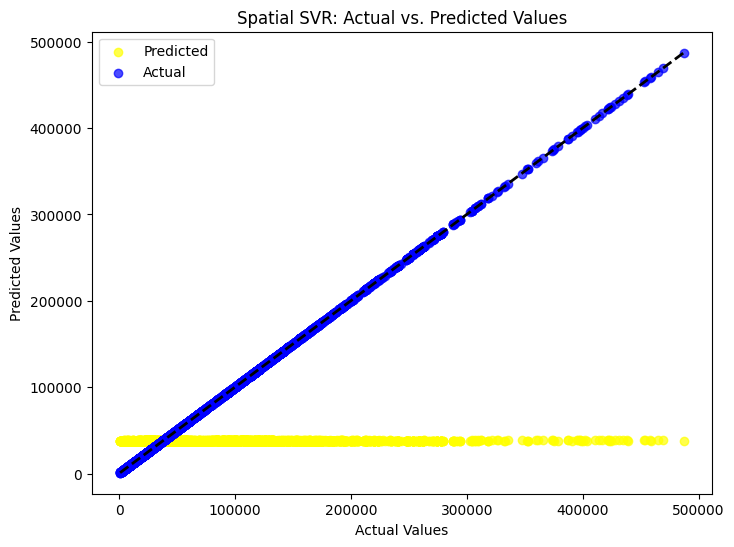

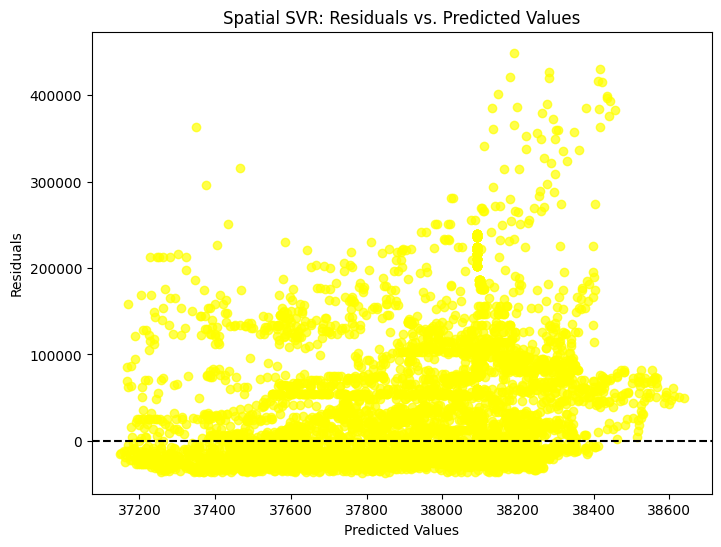

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


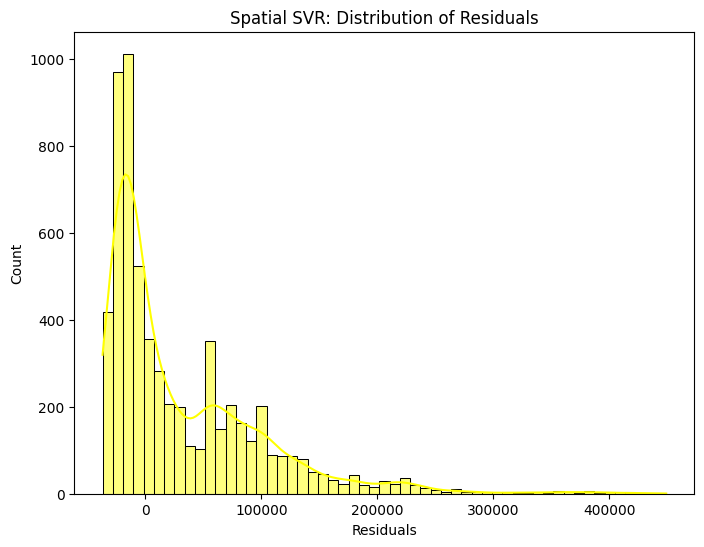

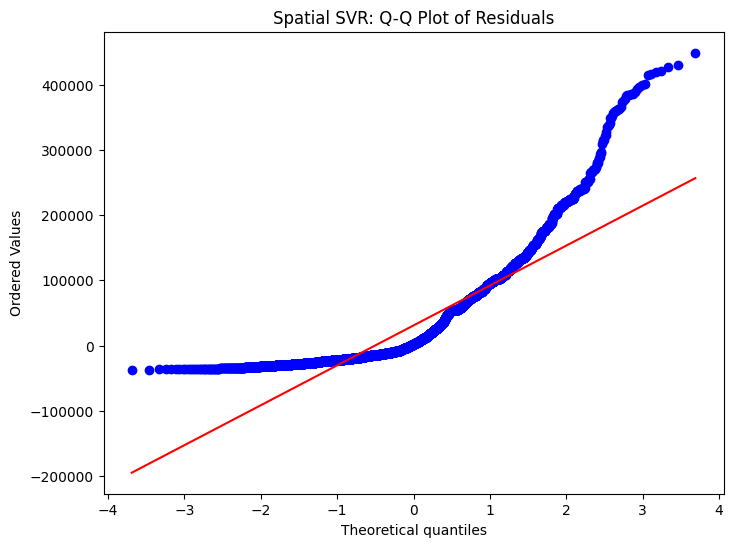

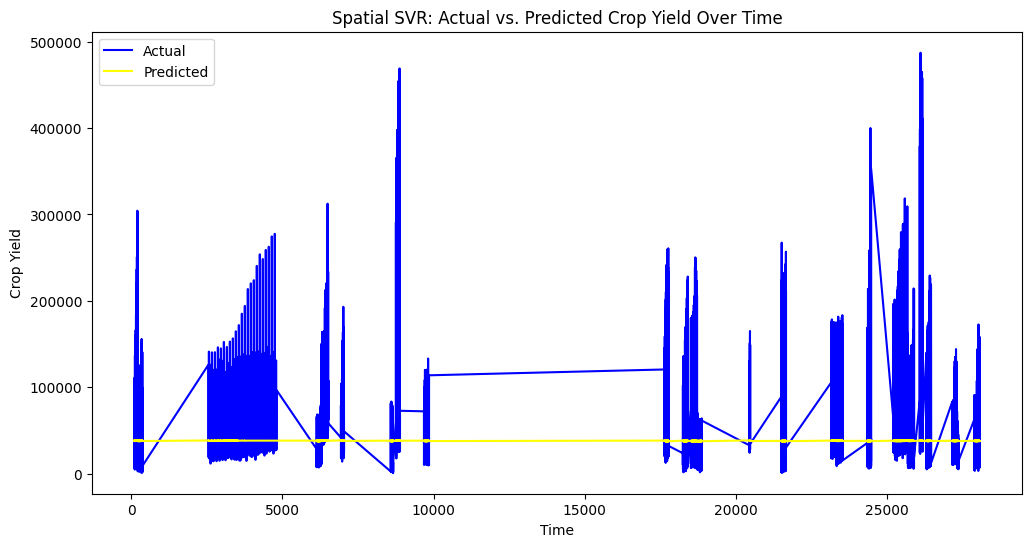

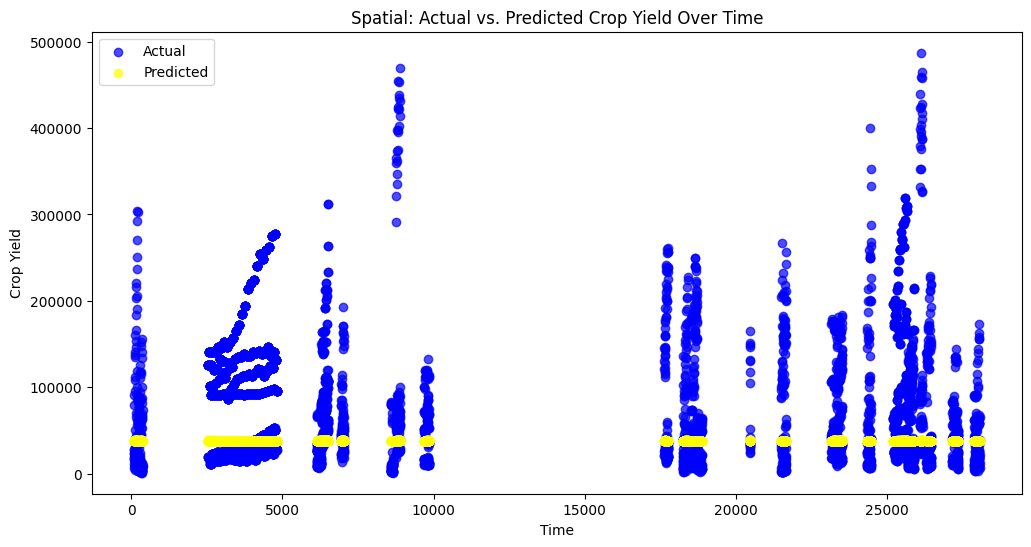

In [38]:
# Scatter Plot: Actual vs. Predicted Values
plt.figure(figsize=(8, 6))
plt.scatter(test_spatial_y, predictions_svr_spatial, alpha=0.7, color='yellow', label='Predicted')
plt.scatter(test_spatial_y, test_spatial_y, alpha=0.7, color='blue', label='Actual')  # To distinguish actual vs predicted
plt.plot([test_spatial_y.min(), test_spatial_y.max()], [test_spatial_y.min(), test_spatial_y.max()], 'k--', lw=2)
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Spatial SVR: Actual vs. Predicted Values")
plt.legend()
plt.show()

# Residuals vs. Predicted Values (Residual Plot)
residuals_svr_spatial = test_spatial_y - predictions_svr_spatial
plt.figure(figsize=(8, 6))
plt.scatter(predictions_svr_spatial, residuals_svr_spatial, alpha=0.7, color='yellow')
plt.axhline(y=0, color='k', linestyle='--')
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.title("Spatial SVR: Residuals vs. Predicted Values")
plt.show()

# Distribution of Residuals (Histogram or KDE)
plt.figure(figsize=(8, 6))
sns.histplot(residuals_svr_spatial, kde=True, color='yellow')
plt.xlabel("Residuals")
plt.title("Spatial SVR: Distribution of Residuals")
plt.show()

# Q-Q Plot (Quantile-Quantile Plot)
plt.figure(figsize=(8, 6))
stats.probplot(residuals_svr_spatial, dist="norm", plot=plt)
plt.title("Spatial SVR: Q-Q Plot of Residuals")
plt.show()

# Prediction Error Plot (Optional, but useful for time series)
predictions_df_svr_spatial = pd.DataFrame({'Actual': test_spatial_y, 'Predicted': predictions_svr_spatial}, index = test_spatial_y.index)
plt.figure(figsize=(12, 6))
plt.plot(predictions_df_svr_spatial['Actual'], label='Actual', color='blue')
plt.plot(predictions_df_svr_spatial['Predicted'], label='Predicted', color='yellow')
plt.xlabel("Time")
plt.ylabel("Crop Yield")
plt.title("Spatial SVR: Actual vs. Predicted Crop Yield Over Time")
plt.legend()
plt.show()

predictions_df_spatial = pd.DataFrame({'Actual': test_spatial_y, 'Predicted': predictions_spatial}, index = test_spatial_y.index)

plt.figure(figsize=(12, 6))

# Scatter plot for actual values
plt.scatter(predictions_df_spatial.index, predictions_df_spatial['Actual'], label='Actual', color='blue', alpha=0.7)

# Scatter plot for predicted values
plt.scatter(predictions_df_spatial.index, predictions_df_spatial['Predicted'], label='Predicted', color='yellow', alpha=0.7)

plt.xlabel("Time")
plt.ylabel("Crop Yield")
plt.title("Spatial: Actual vs. Predicted Crop Yield Over Time")  # Added Spatial to the title
plt.legend()
plt.show()

>another hyper parameter tuning to see if we can get a much better model for the **Spatial Data** 

In [39]:
# param_grid_svr_spatial = {'C': [0.1, 1], 'gamma': [1, 0.1], 'kernel': ['rbf']}

param_grid_svr_spatial = {'C': [0.1, 1, 10, 100], 'gamma': [1, 0.1, 0.01, 0.001], 'kernel': ['rbf', 'linear']}
grid_search_svr_spatial = GridSearchCV(SVR(), param_grid_svr_spatial, cv=KFold(n_splits=5), scoring='neg_root_mean_squared_error', return_train_score=True, n_jobs=1)
grid_search_svr_spatial.fit(train_spatial_X_scaled, train_spatial_y)
best_svr_spatial = grid_search_svr_spatial.best_estimator_
best_svr_score = grid_search_svr_spatial.best_score_
print(best_svr_score)

-93081.98353522822


Display the best parameters of the best model we got

In [40]:
print(grid_search_svr_spatial.best_params_)

{'C': 100, 'gamma': 1, 'kernel': 'linear'}


>Testing the model on **Spatial Data** using the test data on the best model we have got after tuning it for the second time

In [41]:
predictions_svr_spatial = best_svr_spatial.predict(test_spatial_X_scaled)
mse_spatial = mean_squared_error(test_spatial_y, predictions_svr_spatial)
rmse_spatial = np.sqrt(mse_spatial)
mae_spatial = mean_absolute_error(test_spatial_y, predictions_svr_spatial)
r2_spatial = r2_score(test_spatial_y, predictions_svr_spatial)
print("\nTemporal Model Evaluation (Test Set):")
print(f"MSE: {mse_spatial}, RMSE: {rmse_spatial}, MAE: {mae_spatial}, R-squared: {r2_spatial}")


Temporal Model Evaluation (Test Set):
MSE: 4773298974.098608, RMSE: 69089.06551762448, MAE: 47484.36107261278, R-squared: -0.022721774996030675


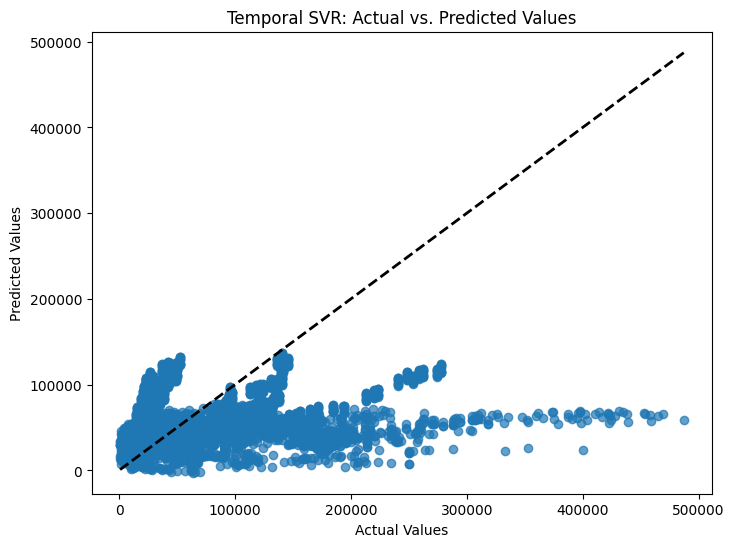

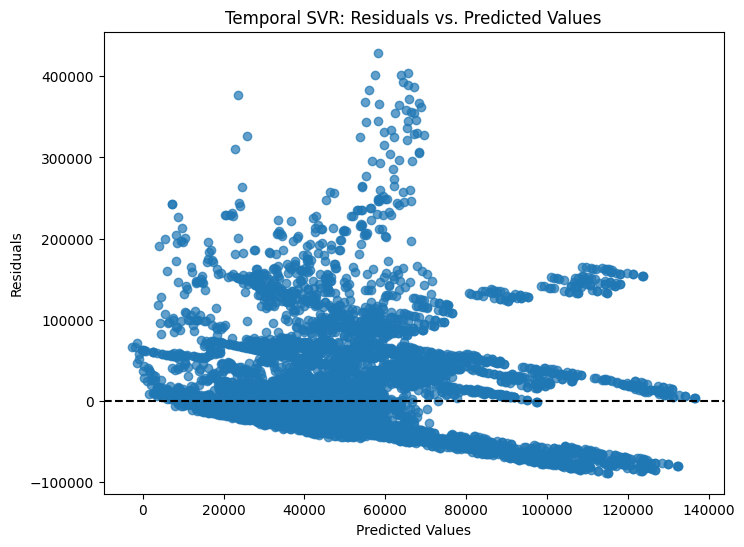

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


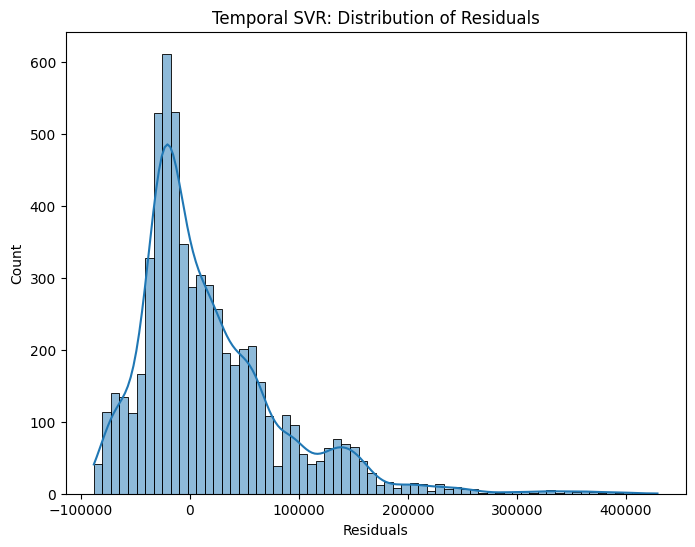

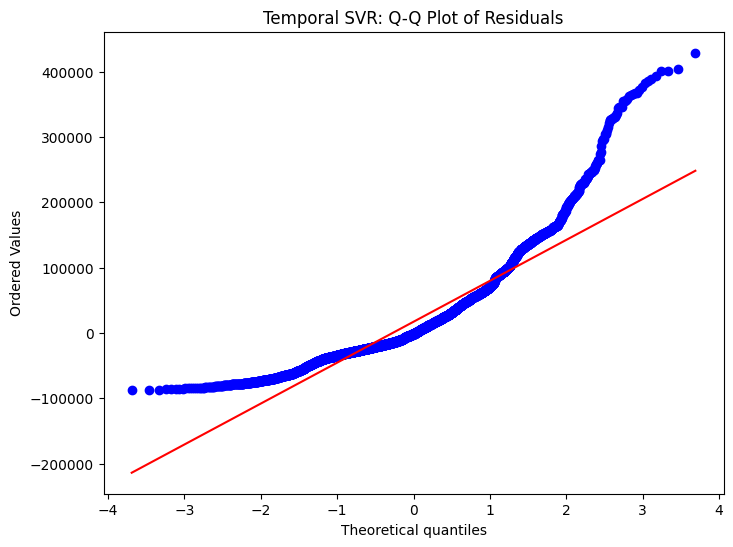

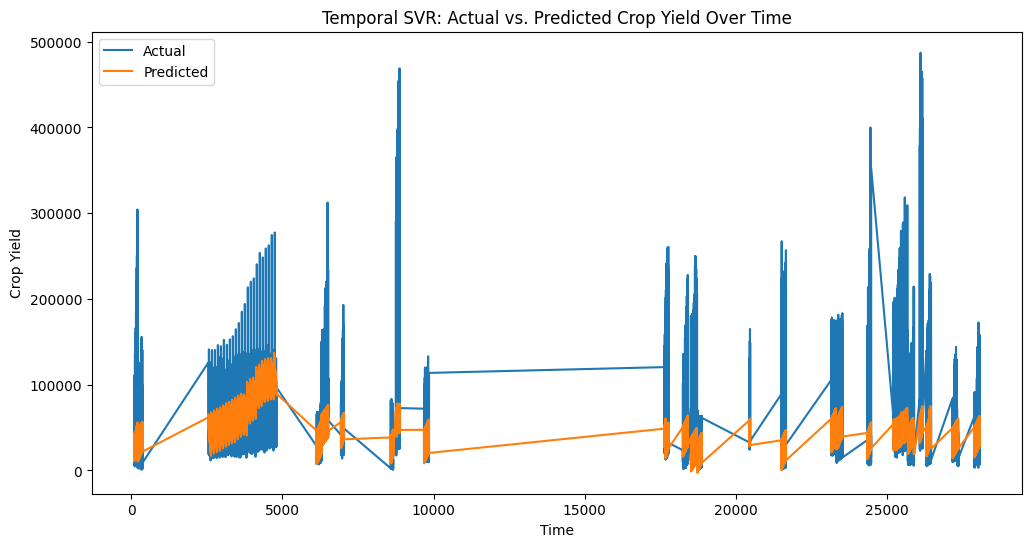

In [42]:
# Actual vs. Predicted Values (Scatter Plot)
plt.figure(figsize=(8, 6))
plt.scatter(test_spatial_y, predictions_svr_spatial, alpha=0.7)
plt.plot([test_spatial_y.min(), test_spatial_y.max()], [test_spatial_y.min(), test_spatial_y.max()], 'k--', lw=2)
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Temporal SVR: Actual vs. Predicted Values")
plt.show()

# Residuals vs. Predicted Values (Residual Plot)
residuals_svr_spatial = test_spatial_y - predictions_svr_spatial
plt.figure(figsize=(8, 6))
plt.scatter(predictions_svr_spatial, residuals_svr_spatial, alpha=0.7)
plt.axhline(y=0, color='k', linestyle='--')
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.title("Temporal SVR: Residuals vs. Predicted Values")
plt.show()

# Distribution of Residuals (Histogram or KDE)
plt.figure(figsize=(8, 6))
sns.histplot(residuals_svr_spatial, kde=True)
plt.xlabel("Residuals")
plt.title("Temporal SVR: Distribution of Residuals")
plt.show()

# Q-Q Plot (Quantile-Quantile Plot)
plt.figure(figsize=(8, 6))
stats.probplot(residuals_svr_spatial, dist="norm", plot=plt)
plt.title("Temporal SVR: Q-Q Plot of Residuals")
plt.show()

# Prediction Error Plot (Optional, but useful for time series)
predictions_df_svr_spatial = pd.DataFrame({'Actual': test_spatial_y, 'Predicted': predictions_svr_spatial}, index = test_spatial_y.index)
plt.figure(figsize=(12, 6))
plt.plot(predictions_df_svr_spatial['Actual'], label='Actual')
plt.plot(predictions_df_svr_spatial['Predicted'], label='Predicted')
plt.xlabel("Time")
plt.ylabel("Crop Yield")
plt.title("Temporal SVR: Actual vs. Predicted Crop Yield Over Time")
plt.legend()
plt.show()